<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Наша задача обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75.

Этапы работы:

1. Загрузка и подготовка данные.
2. Обучение моделей.
3. Выводы.

**Описание данных:**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Знакомство с данными и подготовка данных

In [ ]:
!pip install pymystem3

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize

from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.metrics import f1_score

from time import time

import warnings
warnings.filterwarnings('ignore')

RS = 52

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

stopwords = list(nltk_stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Загрузили данные:

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv')

Провели первичный обзор:

In [ ]:
display(data.head())
print(data.duplicated().sum())
display(data.describe())

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


0


,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


Подготовили функции для обработки текста:

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

def clear_text(text):
    re_text = re.sub(r'[^a-zA-Z ]', ' ', text.lower())
    re_text = re_text.split()
    re_text = " ".join(re_text)
    return re_text

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmetize(words):
    lemmatizer = WordNetLemmatizer()
    text = []
    tokens = word_tokenize(words)
    for token in tokens:
        lemmetized_word = lemmatizer.lemmatize(token, get_wordnet_pos(token))
        text.append(lemmetized_word)
    sentence = " ".join(text)
    return sentence

Перевели сокращения в полную форму:

In [ ]:
%%time

data['lemm_text'] = data['text'].apply(clean_text)
data.head()

CPU times: user 7.17 s, sys: 62.8 ms, total: 7.23 s
Wall time: 7.23 s


,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Избавились от лишних символов и заглавных букв:

In [ ]:
%%time

data['lemm_text'] = data['lemm_text'].apply(clear_text)
data.head()

CPU times: user 1.22 s, sys: 56.2 ms, total: 1.27 s
Wall time: 1.27 s


,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i am s...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i am really not trying to edit war it ...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i cannot make any real suggestions on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


Провели лемматизацию:

In [ ]:
%%time

data['lemm_text'] = data['lemm_text'].apply(lemmetize)
data.head()

CPU times: user 15min 7s, sys: 1min 32s, total: 16min 39s
Wall time: 16min 39s


,Unnamed: 0,text,toxic,lemm_text
0,0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i be see...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man i be really not try to edit war it jus...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,more i can not make any real suggestion on imp...
4,4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Удалили ненужные столбцы:

In [ ]:
data = data.drop(['text', 'Unnamed: 0'], axis=1)
data.head()

,toxic,lemm_text
0,0,explanation why the edits made under my userna...
1,0,d aww he match this background colour i am see...
2,0,hey man i am really not trying to edit war it ...
3,0,more i can not make any real suggestion on imp...
4,0,you sir are my hero any chance you remember wh...


Выделили целевой признак и разбили данные на выборки:

In [ ]:
X = data.drop('toxic', axis=1)
y = data['toxic']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.2, random_state=52, stratify=data['toxic'])
print(train_X.shape, test_X.shape)

(127433, 1) (31859, 1)


Проверили баланс классов:

In [ ]:
print(train_y.value_counts(normalize=True))
print(test_y.value_counts(normalize=True))

0    0.898386
1    0.101614
Name: toxic, dtype: float64
0    0.898396
1    0.101604
Name: toxic, dtype: float64


Провели векторизацию данных:

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))
train_tf_idf = count_tf_idf.fit_transform(train_X)
test_tf_idf = count_tf_idf.transform(test_X)

print("Размер матрицы:", train_tf_idf.shape)
print("Размер матрицы:", test_tf_idf.shape)

Размер матрицы: (127433, 2235872)
Размер матрицы: (31859, 2235872)


## Обучение моделей

Подготовили таблицу для результатов и функцию для подбора параметров:

In [ ]:
analisys = pd.DataFrame({'model':[], 'F1_model':[], 'F1_on_train':[]})
all_models = []

def train_model(model, parameters):

    model_random = RandomizedSearchCV(
        estimator=model,
        param_distributions=parameters,
        scoring='f1',
        n_jobs=-1,
        cv=4,
        verbose=2
    )

    # подсчитаем скорость вычисления
    start = time()
    model_random.fit(train_tf_idf, train_y)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    # высчитаем метрики
    f1 = model_random.best_score_
    f1_on_train = f1_score(train_y, model_random.predict(train_tf_idf))

    print('Лучшие параметры:', model_random.best_params_)
    print('F1 обученной модели:', f1)
    print('F1 на тренировочной выборке:', f1_on_train)

    # заполним все таблицы
    all_models.append(model_random)
    row = []
    row.extend([model, f1, f1_on_train])
    analisys.loc[len(analisys.index)] = row

    return model_random

### Модель логистической регресси

In [ ]:
linear_params = {
    "penalty": ['l1', 'l2', 'elasticnet', 'none'],
    "class_weight": ['balanced', 'none'],
}

lin_model = LogisticRegression()

lr_random = train_model(lin_model, linear_params)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
RandomizedSearchCV подбирал параметры 359.96 секунд
Лучшие параметры: {'penalty': 'l2', 'class_weight': 'balanced'}
F1 обученной модели: 0.7540445227624967
F1 на тренировочной выборке: 0.8989464104448878


### Модель Дерева решений

In [ ]:
tree_params = {
    "max_depth": list(range(20, 30, 2))
}

tree = DecisionTreeClassifier(random_state=RS)

tree_model = train_model(tree, tree_params)

Fitting 4 folds for each of 5 candidates, totalling 20 fits
RandomizedSearchCV подбирал параметры 2673.21 секунд
Лучшие параметры: {'max_depth': 28}
F1 обученной модели: 0.6715166919715042
F1 на тренировочной выборке: 0.7358245563410764


### Модель Случайного леса

In [ ]:
forest_params = {
    'max_depth': [300, 320],
    'n_estimators': [12, 14],
}

forest = RandomForestClassifier(n_jobs=-1, random_state=RS)

forest_model = train_model(forest, forest_params)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
RandomizedSearchCV подбирал параметры 4472.79 секунд
Лучшие параметры: {'n_estimators': 12, 'max_depth': 320}
F1 обученной модели: 0.2964849850631234
F1 на тренировочной выборке: 0.6018138630965234


### LGBM модель

In [ ]:
lgbm_params = {
    'max_depth': [15, 25],
    'learning_rate': [0.2, 0.3]
}

lgbm = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_jobs=-1,
    random_state=RS
)

lgbm_model = train_model(lgbm, lgbm_params)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
RandomizedSearchCV подбирал параметры 420.56 секунд
Лучшие параметры: {'max_depth': 25, 'learning_rate': 0.3}
F1 обученной модели: 0.762486917225315
F1 на тренировочной выборке: 0.8546819034623913


Вывели результаты всех обученных моделей:

,model,F1_model,F1_on_train,names
0,"RandomizedSearchCV(cv=4, estimator=LogisticReg...",0.754045,0.898946,LogisticRegression
1,"RandomizedSearchCV(cv=4, estimator=DecisionTre...",0.671517,0.735825,DecisionTree
2,"RandomizedSearchCV(cv=4,\n e...",0.296485,0.601814,RandomForest
3,"RandomizedSearchCV(cv=4, estimator=LGBMClassif...",0.762487,0.854682,LightGBM


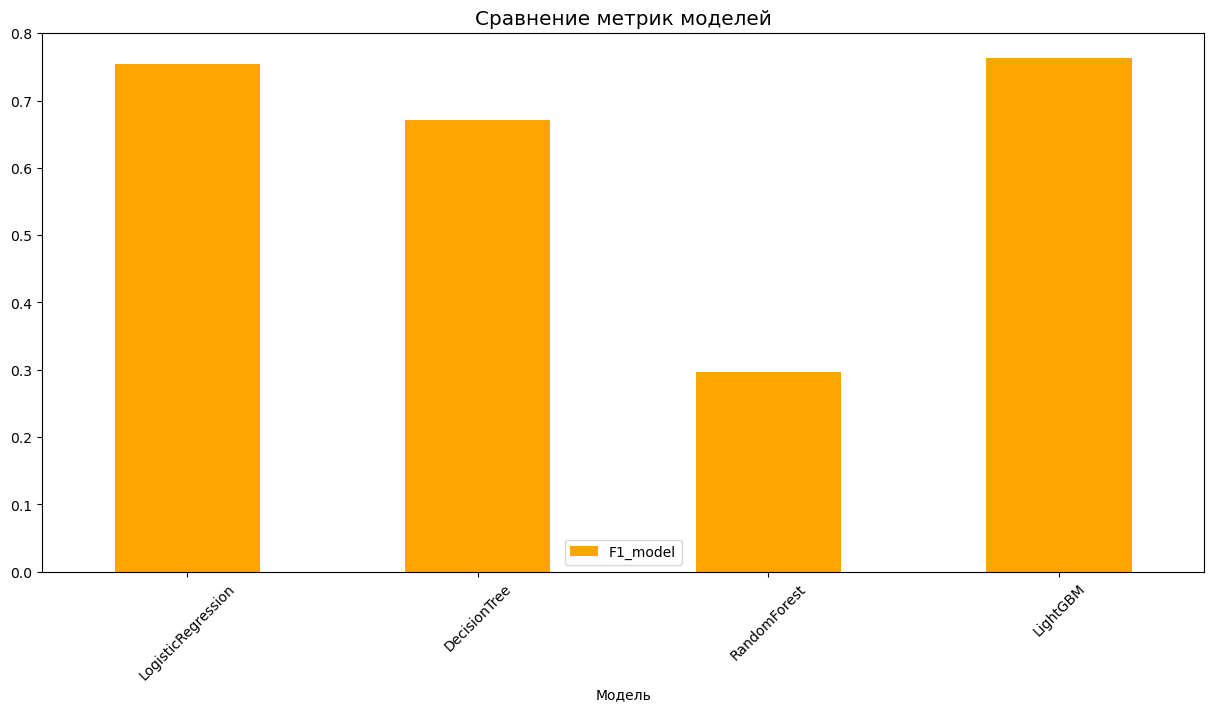

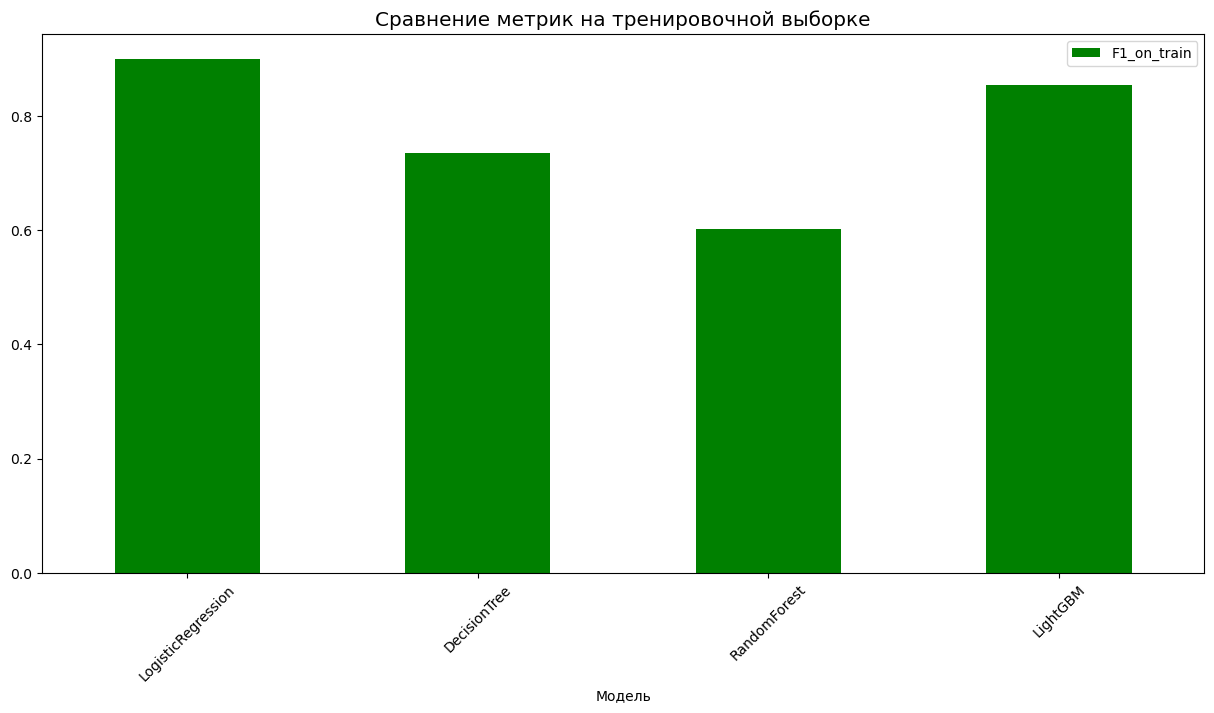

In [ ]:
all_names = pd.DataFrame({'names':['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']})
analisys = pd.concat([analisys, all_names], axis=1, join='inner')
display(analisys)

analisys.plot.bar(y='F1_model', x='names', rot=45, figsize=(15,7), color='orange')
plt.title('Сравнение метрик моделей', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

analisys.plot.bar(y='F1_on_train', x='names', rot=45, figsize=(15,7), color='green')
plt.title('Сравнение метрик на тренировочной выборке', fontsize='x-large')
plt.xlabel('Модель')
plt.show()

Протестировали лучшую модель:

In [ ]:
pred = lgbm_model.predict(test_tf_idf)
print('F1 лучшей модели на тестовой выборке:', f1_score(test_y, pred))

F1 лучшей модели на тестовой выборке: 0.7892630876958986


## Выводы

В ходе работы были пройдены следующие шаги:
   - Заменены сокращения на полные формы слов
   - Удалены все знаки препинания и прочие символы-не буквы
   - Проведена лемматизация текста

Были обучены и получены метрики по следующим моделям:
   - Логистическая регрессия
   - Дерево решений
   - Случайный лес
   - LGBM Классификатор

Лучшее значение метрики качества (F1) было получено в LGBM модели, поэтому эта, уже обученная модель была использована на тестовой выборке.

Полученное значение F1 на тестовой выборке составило 0.789, что соответствует условиям задачи.